<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500000 entries, 2010-01-01 to 2017-07-28
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          500000 non-null  object 
 1   Country         500000 non-null  object 
 2   Item Type       500000 non-null  object 
 3   Sales Channel   500000 non-null  object 
 4   Order Priority  500000 non-null  object 
 5   Order ID        500000 non-null  int64  
 6   Ship Date       500000 non-null  object 
 7   Units Sold      500000 non-null  int64  
 8   Unit Price      500000 non-null  float64
 9   Unit Cost       500000 non-null  float64
 10  Total Revenue   500000 non-null  float64
 11  Total Cost      500000 non-null  float64
 12  Total Profit    500000 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 53.4+ MB
None
                                       Region      Country   Item Type  \
Order Date                               

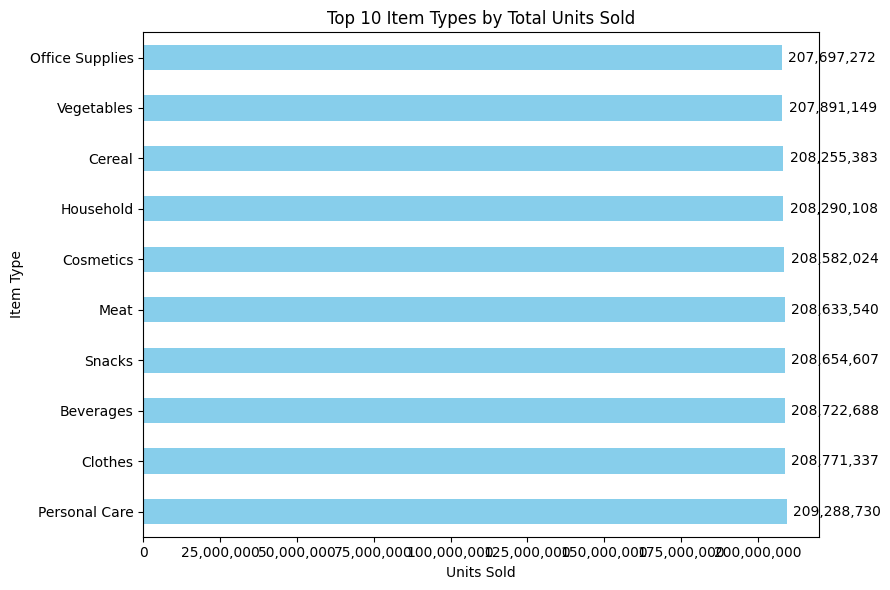

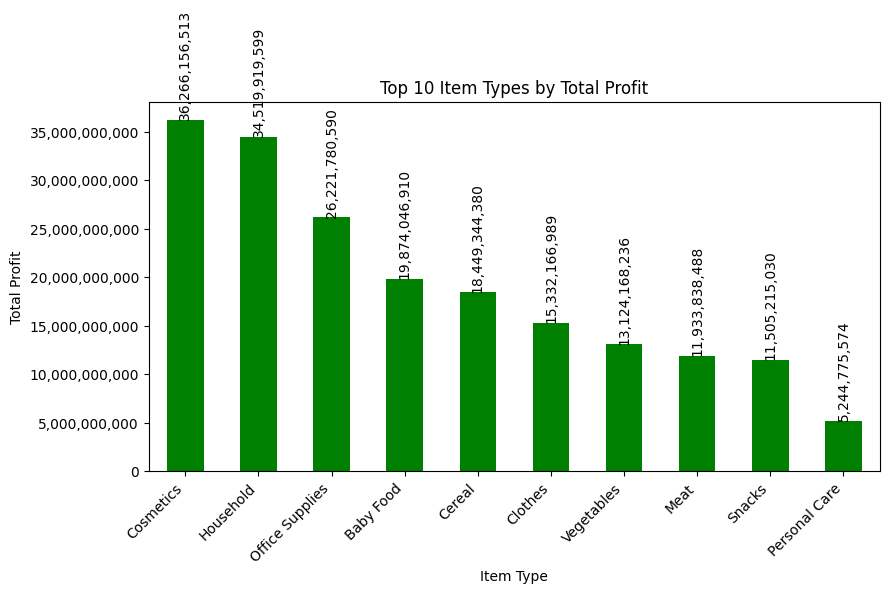

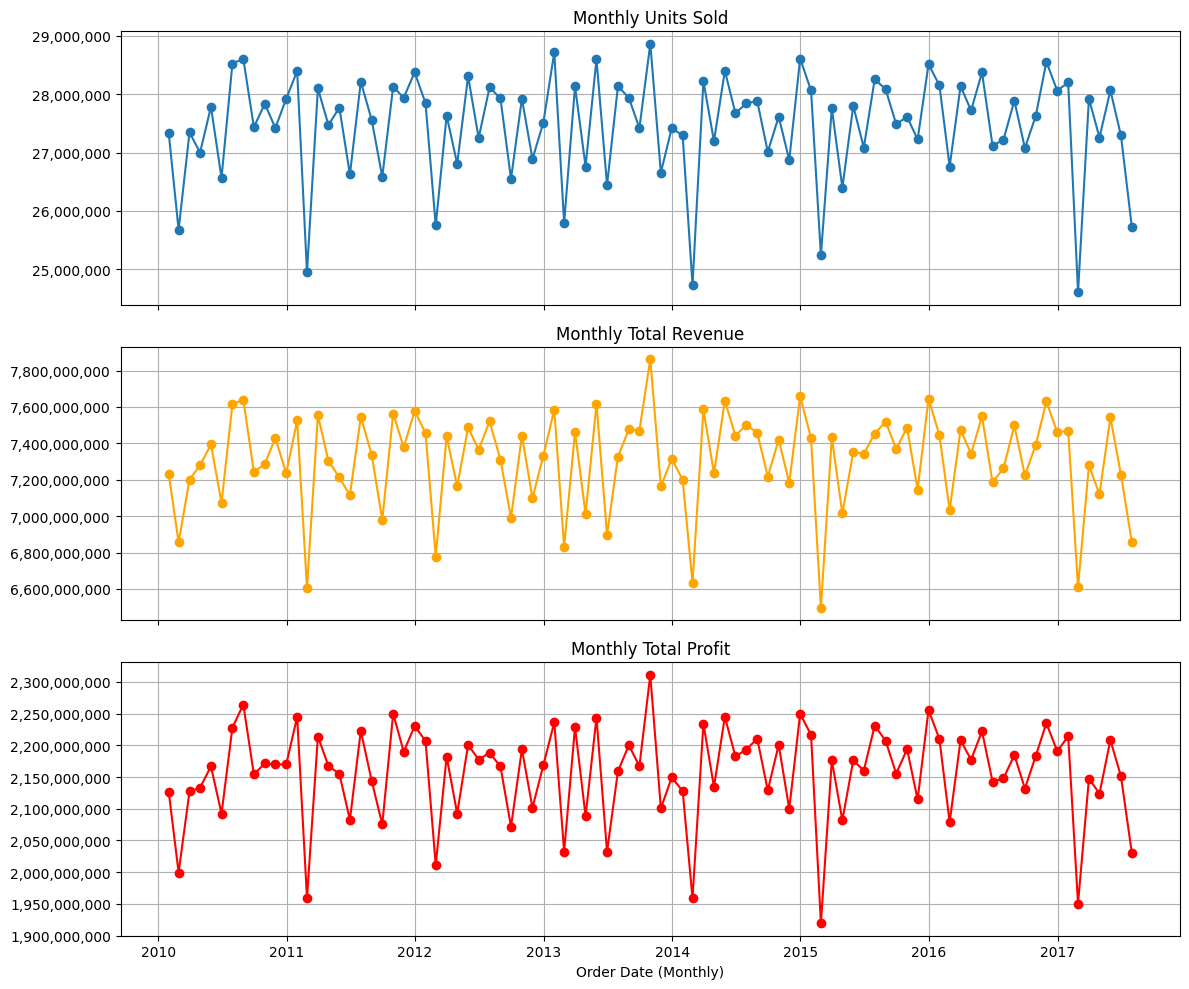

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ----- 1. Load and Clean the Data -----

df = pd.read_csv("arima_sales.csv")

# Convert 'Order Date' to datetime, sort, and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df.sort_values('Order Date', inplace=True)
df.set_index('Order Date', inplace=True)

print(df.info())
print(df.head())

# ----- 2. Top 10 Item Types by Total Units Sold (Horizontal Bar) -----

# Group by item type and sum units sold
top_units = (
    df.groupby("Item Type")['Units Sold']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(9, 6))
top_units.plot(kind='barh', color='skyblue', ax=ax)

ax.set_title("Top 10 Item Types by Total Units Sold")
ax.set_xlabel("Units Sold")
ax.set_ylabel("Item Type")

# Format the x-axis to avoid scientific notation
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Annotate bars with numeric values
for patch in ax.patches:
    value = patch.get_width()
    ax.annotate(
        f'{value:,.0f}',  # comma formatting
        (value + (0.01 * value), patch.get_y() + 0.5 * patch.get_height()),
        va='center'
    )

plt.tight_layout()
plt.show()

# ----- 3. Top 10 Item Types by Total Profit (Vertical Bar) -----

top_profit = (
    df.groupby("Item Type")['Total Profit']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(9, 6))
top_profit.plot(kind='bar', color='green', ax=ax)

ax.set_title("Top 10 Item Types by Total Profit")
ax.set_xlabel("Item Type")
ax.set_ylabel("Total Profit")

# Format the y-axis
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Annotate bars with numeric values
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f'{height:,.0f}',
        (patch.get_x() + patch.get_width() / 2, height),
        ha='center',
        va='bottom',
        rotation=90
    )

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----- 4. Monthly Time Series (Units Sold, Total Revenue, Total Profit) -----

# Resample monthly and sum
df_monthly = df.resample('ME').sum(numeric_only=True)

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# a) Monthly Units Sold
axs[0].plot(df_monthly.index, df_monthly['Units Sold'], marker='o', linestyle='-')
axs[0].set_title("Monthly Units Sold")
axs[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# b) Monthly Total Revenue
axs[1].plot(df_monthly.index, df_monthly['Total Revenue'], color='orange', marker='o', linestyle='-')
axs[1].set_title("Monthly Total Revenue")
axs[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# c) Monthly Total Profit
axs[2].plot(df_monthly.index, df_monthly['Total Profit'], color='red', marker='o', linestyle='-')
axs[2].set_title("Monthly Total Profit")
axs[2].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for ax in axs:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(True)

axs[2].set_xlabel("Order Date (Monthly)")

plt.tight_layout()
plt.show()



[('Baby Food', np.float64(2293362.890242402)), ('Cereal', np.float64(2246243.6062240354)), ('Office Supplies', np.float64(2233902.1460904162))]


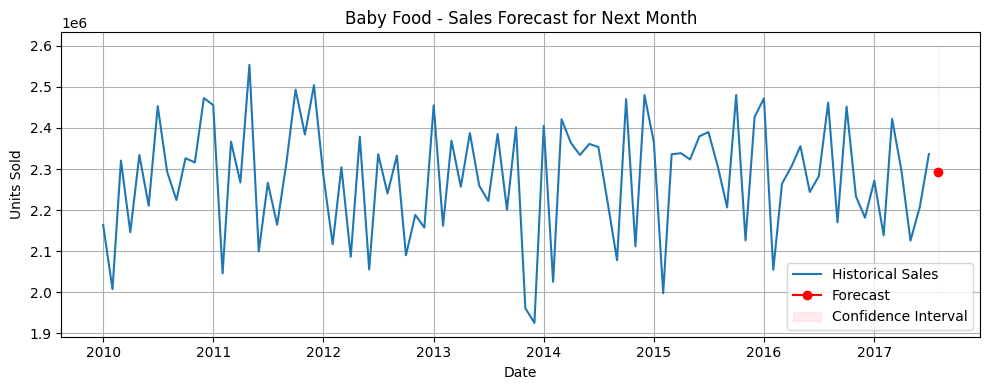

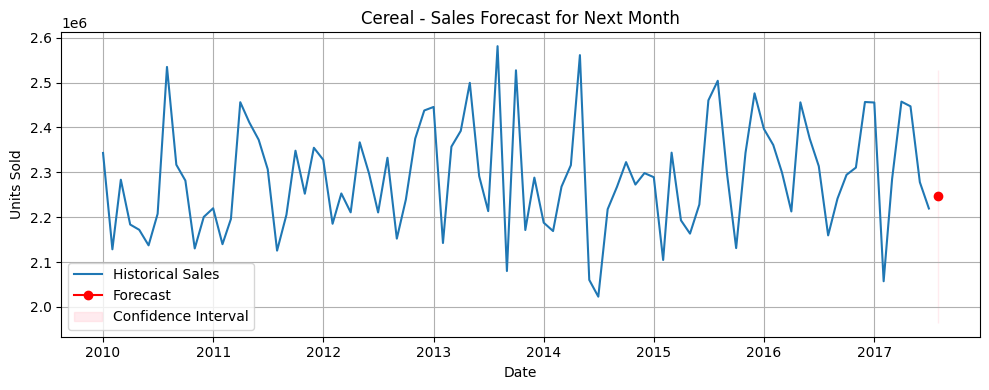

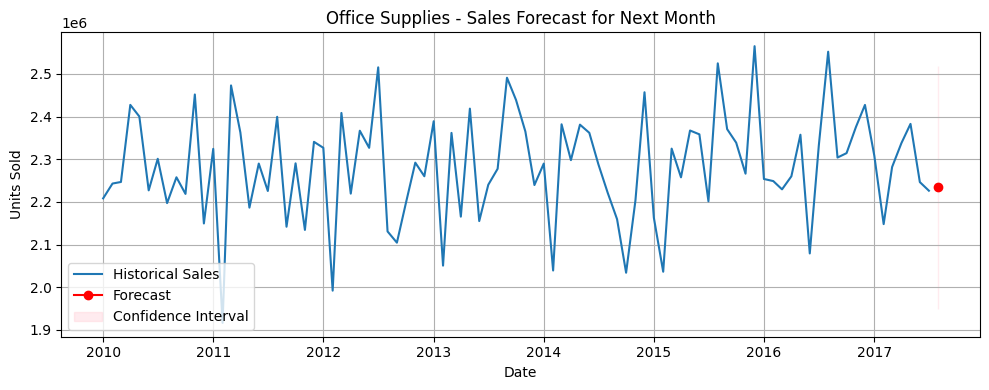

In [6]:
# Load the sales data from the uploaded CSV
file_path = "arima_sales.csv"
sales_data = pd.read_csv(file_path)

# Display the first few rows and column names to understand the structure
sales_data.head(), sales_data.columns

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Convert Order Date to datetime
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

# Aggregate monthly units sold per item type
sales_data['YearMonth'] = sales_data['Order Date'].dt.to_period('M')
monthly_sales = sales_data.groupby(['Item Type', 'YearMonth'])['Units Sold'].sum().unstack(level=0).fillna(0)

# Forecast next month's sales using ARIMA for each item type
forecast_results = {}
for item in monthly_sales.columns:
    series = monthly_sales[item]
    try:
        model = ARIMA(series, order=(1,1,1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1)
        forecast_results[item] = forecast.iloc[0]
    except:
        continue  # skip items that fail to model

# Sort items by forecasted value and get top 3
top_items = sorted(forecast_results.items(), key=lambda x: x[1], reverse=True)[:3]

print (top_items)

for item, forecast in top_items:
    series = monthly_sales[item]
    model = ARIMA(series, order=(1, 1, 1))
    model_fit = model.fit()
    pred = model_fit.get_forecast(steps=1)
    pred_ci = pred.conf_int()

    # Prepare plot
    plt.figure(figsize=(10, 4))
    plt.plot(series.index.to_timestamp(), series, label='Historical Sales')
    plt.plot([series.index[-1].to_timestamp() + pd.offsets.MonthBegin()],
             [forecast], marker='o', label='Forecast', color='red')
    plt.fill_between([series.index[-1].to_timestamp() + pd.offsets.MonthBegin()],
                     pred_ci.iloc[:, 0],
                     pred_ci.iloc[:, 1],
                     color='pink', alpha=0.3, label='Confidence Interval')

    plt.title(f"{item} - Sales Forecast for Next Month")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
